# LIT-PCBA 
this dataset is a proposed "more difficult" test than DUD-E. I used a 75/25 (sklearn default) stratified split. The dataset is heavily imbalanced, like DUD-E.

In [1]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import sys
# sys.path.append('..')
sys.path.insert(0, "/g/g13/jones289/workspace/hd-cuda-master")
# print(sys.path)
import hdpy
import hdpy.ecfp
# from hdpy.analysis import load_pkl
from hdpy.metrics import compute_enrichment_factor
from pathlib import Path


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)


# SEED=125
SEED=5
# SEED=2

# Todo: visualize the learning curves 

In [2]:
data_p = Path(f"/p/vast1/jones289/hd_results/{SEED}")

In [3]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
rocket_color_pal = sns.color_palette("rocket", 10)

In [4]:
model_dict = {
#     "hdbind-rp-molformer": ("HDBind+MolFormer", rocket_color_pal[0]),
#     "hdbind-rp-ecfp-1024-1": ("HDBind+ECFP-1024-1", rocket_color_pal[2]),
#     "hdbind-rp-ecfp-1024-2": ("HDBind+ECFP-1024-1", rocket_color_pal[2]),
#     "hdbind-rp-ecfp-1024-4": ("HDBind+ECFP-1024-1", rocket_color_pal[2]),
#     "hdbind-rp-ecfp-2048-1": ("HDBind+ECFP-1024-1", rocket_color_pal[2]),
#     "hdbind-rp-ecfp-2048-2": ("HDBind+ECFP-1024-1", rocket_color_pal[2]),
#     "hdbind-rp-ecfp-2048-4": ("HDBind+ECFP-1024-1", rocket_color_pal[2]),
    "molehd-bpe": ("MoleHD-BPE", rocket_color_pal[4]),
#     "smiles-pe.atomwise.0": rocket_color_pal[2],
#     "smiles-pe.bpe.0": rocket_color_pal[4],   
# "selfies.atomwise": green_color_pal[4],
#     "ecfp": green_color_pal[6],
#     "rp": green_color_pal[8],
#     "rf": blue_color_pal[4],
#     "mlp": blue_color_pal[7],
#     "HDC-MLP": green_color_pal[9],
#     "HDC-RF": green_color_pal[9],
#     "Vina": "salmon",
}


# model_order_list = [
#     ("hdbind-rp-molformer", )
#     ("smiles-pe.atomwise.0", "MoleHD-Atomw."),
#     ("smiles-pe.bpe.0", "MoleHD-BPE"),
#     ("smiles-pe.ngram.1", "SMILES uni-gram"),
#     ("selfies.atomwise", "HDBind-SELFIES"),
#     ("selfies.selfies-charwise", "SELFIES uni-gram"),
#     ("ecfp", "HDBind-ECFP"),
#     ("rp", "HDBind-ECFP+RP"),
#     ("rf", "RF"),
#     ("mlp", "MLP"),
#     ("Vina", "Vina")
# ]


# model_name_dict = {
#     "hdbind-rp-molformer": "HDBind+MolFormer"
#     "smiles-pe.atomwise.0": "MoleHD-Atomw.", 
#     "smiles-pe.bpe.0": "MoleHD-BPE",
#     "smiles-pe.ngram.1": "SMILES uni-gram",
#     "selfies.atomwise": "HDBind-SELFIES",
#     "selfies.selfies-charwise": "SELFIES uni-gram",
#     "ecfp": "HDBind-ECFP",
#     "rp": "HDBind-RPFP",
#     "rf": "RF",
#     "mlp": "MLP",
#     "Vina": "Vina",
#     "HDC-MLP": "HDC-MLP",
#     "HDC-RF": "HDC-RF"
# }

# LIT-PCBA Results

export CONDA_ROOT=/usr/workspace/jones289/anaconda3-power #installed using the LC installer script
export PATH=$CONDA_ROOT/bin:$PATH
export CONDA_EXE=$CONDA_ROOT/bin/conda
ml load gcc/11
export PYTHONPATH=$PWD:$PYTHONPATH
source activate /usr/workspace/jones289/anaconda3-power/envs/opence-1.8.0

In [10]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score


def compute_metrics(y_pred, y_score, y_true, p):
    
    return {"precision": precision_score(y_pred=y_pred, y_true=y_true, zero_division=0),
            "recall": recall_score(y_pred=y_pred, y_true=y_true),
           "f1": f1_score(y_pred=y_pred, y_true=y_true, zero_division=0),
            "enrich": float(compute_enrichment_factor(scores=y_score, labels=y_true, n_percent=p)),            
           "roc": roc_auc_score(y_score=y_score, y_true=y_true)
           }


def aggregate_results(dataset, range_limit=10, multistep_initial_p=None, 
                      multistep_p_list=None, 
                      multistep_sklearn_model=None):
    

    model_metric_dict = {"model": [], "enrich": [], "p":[], "train_time":[], "test_time": [], "target": [],
                        "seed": [], "recall": [], "precision": [], "f1": [], 
#                          "roc": []
                        }
#     import ipdb
#     ipdb.set_trace()
    for model_name, model_tup in tqdm(model_dict.items(), total=len(model_dict), position=0):
                        
#         metric_list = []
#         encode_time_list = []
#         train_time_list = []
#         test_time_list = []
#         train_size_list = []
#         test_size_list = []
#         target_size_list = []
#         eta_list = []

        
#         if model not in ["HDC-MLP", "HDC-RF"]:
#             data_path_list = list(data_p.glob(f"{dataset.replace('-','_')}*.{model}*pkl"))

#         elif model in ["HDC-MLP", "HDC-RF"]:
#         data_path_list = list(data_p.glob(f"{dataset}*{model_name}*pkl"))
        data_path_list = list(data_p.glob(f"{model_name}.{dataset}*.pkl"))
        print(f"{model_name}-{dataset}: {len(model_tup)}\t {len(data_path_list)}")

        
# #     '''

        for path in tqdm(data_path_list, total=len(data_path_list), position=1):

            
            with open(path, "rb") as handle:
                model_data_dict = pickle.load(handle)
#             torch.load(path)
            
            target = path.name.split(".")[1]
            
            print(target, path, model_name)


#             import ipdb
#             ipdb.set_trace()
            for seed in range(len(model_data_dict['trials'])):
                trial_dict = model_data_dict['trials'][seed]
#                 import pdb
#                 pdb.set_trace()
#                 print(model_data_dict[seed].keys())
#                 print(trial_dict.keys())
                y_test = model_data_dict["y_test"]
#                 x_test = model_data_dict["x_test"]
                actives_database = sum(y_test)
                database_size = y_test.shape[0]
                
#                 eta = None 
                

#                 if model in ["rf", "mlp"]:


#                     for p in [.01, .1]:

#                         sklearn_model = model_data_dict[seed]["model"]

#                         y_score = sklearn_model.predict_proba(x_test)[:, 1]            
#                         y_pred = sklearn_model.predict(x_test)
#                         enrich = compute_enrichment_factor(sample_scores=y_score, 
#                                                 sample_labels=y_test,
#                                                 n_percent=p, 
#                                                 actives_database=actives_database, 
#                                                 database_size=database_size)

                
#                         metrics = compute_metrics(y_pred=y_pred, y_score=y_score, y_true=y_test)
                
#                         model_metric_dict["model"].append(model)
#                         model_metric_dict["target"].append(target)
#                         model_metric_dict["enrich"].append(enrich)
#                         model_metric_dict["p"].append(p)
#                         model_metric_dict["seed"].append(seed)
#                         model_metric_dict["precision"].append(metrics["precision"])
#                         model_metric_dict["recall"].append(metrics["recall"])
#                         model_metric_dict["f1"].append(metrics["f1"])
# #                         model_metric_dict["roc"].append(metrics["roc"])

                        
#                 elif model.lower() in ["hdc-rf", "hdc-mlp"]:

#                     sklearn_result_file = Path(f"{data_p}/{dataset.replace('-', '_')}.{target}.{multistep_sklearn_model}.None.{ngram_order}.pkl")

#                     with open(sklearn_result_file, "rb") as handle:
#                         sklearn_result_dict = pickle.load(handle)

#                     target_test_hv_path = f"{hd_cache_dir}/{target}/test_dataset_hv.pth"

#                     hv_test = torch.load(target_test_hv_path, map_location="cpu")
#                     hdc_conf_scores = model_data_dict[seed]["model"].compute_confidence(hv_test)

# #                     # filter the data
#                     idxs = np.flip(np.argsort(hdc_conf_scores.squeeze().cpu().numpy(), kind="stable"))

                    
#                     sample_n = int(multistep_initial_p * y_test.shape[0])
#                     samp_idxs = idxs[:sample_n]
                    

#                     x_test_samp = x_test[samp_idxs]
#                     y_test_samp = y_test[samp_idxs]
                                            
    
#                     for p in multistep_p_list:

#                         sklearn_model = sklearn_result_dict[seed]["model"]
            
#                         sklearn_scores_samp = sklearn_model.predict_proba(x_test_samp)[:, 1]                        
            
#                         y_pred = sklearn_model.predict(x_test_samp)
#                         enrich = compute_enrichment_factor(sample_scores=sklearn_scores_samp, 
#                                                 sample_labels=y_test_samp,
#                                                 n_percent=p, 
#                                                 actives_database=actives_database, 
#                                                 database_size=database_size)


#                         metrics = compute_metrics(y_pred=y_pred, y_score=sklearn_scores_samp, y_true=y_test_samp)
                
#                         model_metric_dict["model"].append(model)
#                         model_metric_dict["target"].append(target)
#                         model_metric_dict["enrich"].append(enrich)
#                         model_metric_dict["p"].append(round(multistep_initial_p * p, 2))
#                         model_metric_dict["seed"].append(seed)
#                         model_metric_dict["precision"].append(metrics["precision"])
#                         model_metric_dict["recall"].append(metrics["recall"])
#                         model_metric_dict["f1"].append(metrics["f1"])
# #                         model_metric_dict["roc"].append(metrics["roc"])
                    

#                 else:                  
                    
#                 target_test_hv_path = f"{hd_cache_dir}/{target}/test_dataset_hv.pth"
                
#                 hv_test = torch.load(target_test_hv_path, map_location="cpu")
#                 hdc_conf_scores = model_data_dict[seed]["model"].compute_confidence(hv_test)
                hdc_conf_scores = trial_dict["eta"]
                for p in [.01, .1]:

                    try:
                        metrics = compute_metrics(y_pred=trial_dict["y_pred"], 
                                                  y_score=hdc_conf_scores, 
                                                  y_true=model_data_dict["y_test"],
                                                 p=p)

    #                     model_metric_dict["model"].append(model)
                        model_metric_dict["target"].append(target)
    #                     model_metric_dict["enrich-1"].append(metrics["enrich-1"])
    #                     model_metric_dict["enrich-10"].append(metrics["enrich-10"])
                        model_metric_dict["enrich"].append(metrics["enrich"])
                        model_metric_dict["p"].append(p)
                        model_metric_dict["seed"].append(seed)
                        model_metric_dict["precision"].append(metrics["precision"])
                        model_metric_dict["recall"].append(metrics["recall"])
                        model_metric_dict["f1"].append(metrics["f1"])
    #                     model_metric_dict["roc"].append(metrics["roc"])
                        model_metric_dict["model"].append(model_name)
                    except Exception as e:
                        print(e)

#                 #TODO: implement this 
#                 model_metric_dict["train_time"].append(train_time)
#                 model_metric_dict["test_time"].append(test_time)

    return model_metric_dict
        


In [11]:
model_metric_dict = aggregate_results(dataset="lit-pcba",multistep_p_list=[.05, .5],  
                                          multistep_sklearn_model="rf", 
                                         multistep_initial_p=.2)
# dude_model_metric_dict = aggregate_results(dataset="dude",multistep_p_list=[.05, .5],  
#                                           multistep_sklearn_model="rf", 
#                                          multistep_initial_p=.2)

  0%|          | 0/1 [00:00<?, ?it/s]

molehd-bpe-lit-pcba: 2	 1



  0%|          | 0/1 [00:00<?, ?it/s]

lit-pcba-PKM2 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-PKM2.5.pkl molehd-bpe



100%|██████████| 1/1 [00:13<00:00, 13.91s/it]


In [12]:
model_metric_dict

{'model': ['molehd-bpe',
  'molehd-bpe',
  'molehd-bpe',
  'molehd-bpe',
  'molehd-bpe',
  'molehd-bpe',
  'molehd-bpe',
  'molehd-bpe',
  'molehd-bpe',
  'molehd-bpe',
  'molehd-bpe',
  'molehd-bpe',
  'molehd-bpe',
  'molehd-bpe',
  'molehd-bpe',
  'molehd-bpe',
  'molehd-bpe',
  'molehd-bpe',
  'molehd-bpe',
  'molehd-bpe'],
 'enrich': [7.289553512181249,
  2.7736324546999134,
  5.8316428097449995,
  2.919613110210435,
  7.289553512181249,
  3.1385840934762177,
  7.289553512181249,
  2.9926034379656965,
  5.8316428097449995,
  2.846622782455174,
  7.289553512181249,
  2.919613110210435,
  7.289553512181249,
  2.9926034379656965,
  7.289553512181249,
  2.9926034379656965,
  7.289553512181249,
  2.9926034379656965,
  7.289553512181249,
  2.846622782455174],
 'p': [0.01,
  0.1,
  0.01,
  0.1,
  0.01,
  0.1,
  0.01,
  0.1,
  0.01,
  0.1,
  0.01,
  0.1,
  0.01,
  0.1,
  0.01,
  0.1,
  0.01,
  0.1,
  0.01,
  0.1],
 'train_time': [],
 'test_time': [],
 'target': ['lit-pcba-PKM2',
  'lit-pc

# VINA result

In [13]:
from pathlib import Path
def docking_main(nrows=None):
    root_p = Path("/p/lustre2/ahashare/zhang30/LIT-PCBA-Data/")

    path_list = [path for path in root_p.glob("*-actives.csv")]


    df_list = []

    for idx, path in tqdm(enumerate(path_list), total=len(path_list)):
        print(idx, path)
        
#         '''
        target = path.name.split(".")[0].split("-")[0]
        print(target, idx+1, path)
        
        

        merged_df = None
        merged_df_path = Path(f"./lit_pcba_docking_analysis/{target}.csv")
        
        if not merged_df_path.exists():
            # can use the set of smiles in each result file
            result_pkl = Path(f"/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/124/lit_pcba.{target}.ecfp.atomwise.0.pkl")        


            target_train_smiles_list = []
            target_test_smiles_list = []

            with open(result_pkl, "rb") as handle:

                data = pickle.load(handle)

                target_train_smiles_list = data["smiles_train"]
                target_test_smiles_list = data["smiles_test"]

                print(f"total of {len(target_train_smiles_list)} in training set, total of {len(target_test_smiles_list)} in testing set.")

            df_cols = ['file', ' scores/1', ' ligName']
            active_df = pd.read_csv(root_p / Path(f"{target}-actives.csv.clean"), sep=",", usecols=df_cols, nrows=nrows)
            active_df['y_true'] = [1] * len(active_df)



            inactive_df = pd.read_csv(root_p / Path(f"{target}-inactives.csv.clean"), sep=",", usecols=df_cols, nrows=nrows)
            inactive_df['y_true'] = [0] * len(inactive_df)

            target_df = pd.concat([active_df, inactive_df])
            # this will search over all of the docking results for each target, across each of the multiple protein models

            active_smiles_df = pd.read_csv(f"/p/vast1/jones289/lit_pcba/{target}/actives.smi", delim_whitespace=True, header=None)
            inactive_smiles_df = pd.read_csv(f"/p/vast1/jones289/lit_pcba/{target}/inactives.smi", delim_whitespace=True, header=None)
            target_smiles_df = pd.concat([active_smiles_df, inactive_smiles_df])



            top_pose_target_df = target_df.groupby([' ligName'], as_index=False)[[' ligName', ' scores/1', 'y_true']].min()


        
            merged_df_path.parent.mkdir(exist_ok=True, parents=True)
            merged_df = pd.merge(top_pose_target_df, target_smiles_df, left_on=" ligName", right_on=1)
            merged_df = merged_df[merged_df.apply(lambda x: x[0] in target_test_smiles_list, axis=1)]
            merged_df['target'] = [target] * len(merged_df)
            merged_df.to_csv(merged_df_path, index=False)
        else:
            merged_df = pd.read_csv(merged_df_path)
            
            if 'target' not in merged_df.columns:
                merged_df['target'] = [target] * len(merged_df)
                merged_df.to_csv(merged_df_path, index=False)



        df_list.append(merged_df)

    df = pd.concat(df_list)
    return df

In [14]:
def compute_model_metric_df():
    model_metric_dict = aggregate_results(dataset="lit-pcba",multistep_p_list=[.05, .5],  
                                          multistep_sklearn_model="rf", 
                                         multistep_initial_p=.2)

    model_metric_df = pd.DataFrame({key: value for key, value in model_metric_dict.items() if key not in ["train_time", "test_time", "precision", "recall", "f1"]})

    # model_metric_df

    #######
    vina_result = docking_main(nrows=None)
    vina_result
    ###########

    docking_dict = {"enrich": [], "p": [], "model": [], "target": []}

    vina_enrich_list = []
    target_list = []
    vina_col=' scores/1'
    for target, target_df in vina_result.groupby("target"):

        for p in [.1, .01]:
            enrich = compute_enrichment_factor(scores=np.abs(target_df[vina_col]), 
                                      labels=target_df["y_true"], 
                                      n_percent=p)

            docking_dict["enrich"].append(float(enrich))
            docking_dict["p"].append(p)
            docking_dict["model"].append("Vina")
            docking_dict["target"].append(target)


    ##################
    model_metric_df = pd.concat([model_metric_df, pd.DataFrame(docking_dict)])
    
    # Backup the calculation
    model_metric_df.to_csv("fixed_litpcba_model_metric_df.csv")
    
    return model_metric_df    


In [15]:

model_metric_df = compute_model_metric_df()


  0%|          | 0/1 [00:00<?, ?it/s]

molehd-bpe-lit-pcba: 2	 1



  0%|          | 0/1 [00:00<?, ?it/s]

lit-pcba-PKM2 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-PKM2.5.pkl molehd-bpe



  0%|          | 0/15 [00:00<?, ?it/s]

0 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PKM2-actives.csv
PKM2 1 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PKM2-actives.csv


  7%|▋         | 1/15 [00:00<00:04,  2.94it/s]

1 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/GBA-actives.csv
GBA 2 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/GBA-actives.csv


 13%|█▎        | 2/15 [00:00<00:04,  3.22it/s]

2 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ago-actives.csv
ESR1_ago 3 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ago-actives.csv
3 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MAPK1-actives.csv
MAPK1 4 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MAPK1-actives.csv
4 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/VDR-actives.csv
VDR 5 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/VDR-actives.csv


 33%|███▎      | 5/15 [00:01<00:02,  4.85it/s]

5 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/KAT2A-actives.csv
KAT2A 6 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/KAT2A-actives.csv


 47%|████▋     | 7/15 [00:01<00:01,  4.61it/s]

6 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ALDH1-actives.csv
ALDH1 7 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ALDH1-actives.csv
7 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/TP53-actives.csv
TP53 8 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/TP53-actives.csv
8 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PPARG-actives.csv
PPARG 9 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PPARG-actives.csv
9 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ADRB2-actives.csv
ADRB2 10 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ADRB2-actives.csv


 67%|██████▋   | 10/15 [00:01<00:00,  6.39it/s]

10 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MTORC1-actives.csv
MTORC1 11 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MTORC1-actives.csv
11 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/OPRK1-actives.csv
OPRK1 12 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/OPRK1-actives.csv


 80%|████████  | 12/15 [00:02<00:00,  7.12it/s]

12 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/IDH1-actives.csv
IDH1 13 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/IDH1-actives.csv


 87%|████████▋ | 13/15 [00:02<00:00,  6.00it/s]

13 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ant-actives.csv
ESR1_ant 14 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ant-actives.csv
14 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/FEN1-actives.csv
FEN1 15 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/FEN1-actives.csv


100%|██████████| 15/15 [00:02<00:00,  5.51it/s]


In [16]:
model_metric_df["model"]

0     molehd-bpe
1     molehd-bpe
2     molehd-bpe
3     molehd-bpe
4     molehd-bpe
5     molehd-bpe
6     molehd-bpe
7     molehd-bpe
8     molehd-bpe
9     molehd-bpe
10    molehd-bpe
11    molehd-bpe
12    molehd-bpe
13    molehd-bpe
14    molehd-bpe
15    molehd-bpe
16    molehd-bpe
17    molehd-bpe
18    molehd-bpe
19    molehd-bpe
0           Vina
1           Vina
2           Vina
3           Vina
4           Vina
5           Vina
6           Vina
7           Vina
8           Vina
9           Vina
10          Vina
11          Vina
12          Vina
13          Vina
14          Vina
15          Vina
16          Vina
17          Vina
18          Vina
19          Vina
20          Vina
21          Vina
22          Vina
23          Vina
24          Vina
25          Vina
26          Vina
27          Vina
28          Vina
29          Vina
Name: model, dtype: object

In [17]:
(model_metric_df).groupby(["model", "target", "p"])["enrich"].describe().to_csv("summary_ef_stats.csv")

In [18]:
def make_box_plot(enrich_1_df, enrich_10_df):
    
    enrich_f, enrich_ax = plt.subplots(2,1, figsize=(12,10), sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]
    
#     sns.boxplot(data=enrich_1_df, x="model", y="enrich", ax=enrich_1_ax, palette=color_dict)
    sns.swarmplot(data=enrich_1_df, x="model", y="enrich", ax=enrich_1_ax)
    enrich_1_ax.set_title("(a) LIT-PCBA Enrichment at 1\%", fontdict={"fontsize": 18})
    enrich_1_ax.set_xlabel("")
    enrich_1_ax.set_ylabel("")
    enrich_1_ax.tick_params(axis="x", labelrotation=22.5)

    enrich_1_ax.set_ylabel("EF")

    plt.tight_layout()

    
#     sns.boxplot(data=enrich_10_df, x="model", y="enrich", ax=enrich_10_ax, palette=color_dict)
    sns.swarmplot(data=enrich_10_df, x="model", y="enrich", ax=enrich_10_ax)

    enrich_10_ax.set_title("(b) LIT-PCBA Enrichment at 10\%", fontdict={"fontsize": 18})
    enrich_10_ax.set_xlabel("")
    enrich_10_ax.set_ylabel("")
    enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
    labels = [item.get_text() for item in enrich_10_ax.get_xticklabels()]
#     labels = [model_name_dict[x.get_text()] for x in enrich_10_ax.get_xticklabels()]
#     labels[-1] = combo_model_name
#     enrich_10_ax.set_xticklabels(labels)
    enrich_ax[0].set_ylabel("EF")
    enrich_ax[1].set_ylabel("EF")

    plt.tight_layout()
    # enrich_10_f.savefig("enrich_10.png", dpi=600, bbox_inches="tight")
    # enrich_10_f
    
    enrich_f.savefig("lit-pcba-enrich.png", dpi=600, bbox_inches="tight")

#     return enrich_f

In [19]:
# take the average over the random seeds dimension for each combo of MODEL X TARGET X P
grp_df = (model_metric_df).groupby(["model", "target", "p"])["enrich"].mean().reset_index()


In [20]:
grp_df[grp_df["p"] == .1]

,model,target,p,enrich
1,Vina,ADRB2,0.1,0.000000
3,Vina,ALDH1,0.1,1.593674
5,Vina,ESR1_ago,0.1,2.492105
7,Vina,ESR1_ant,0.1,1.312765
9,Vina,FEN1,0.1,2.079093
11,Vina,GBA,0.1,2.825939
13,Vina,IDH1,0.1,1.999913
15,Vina,KAT2A,0.1,0.784314
17,Vina,MAPK1,0.1,2.375000
19,Vina,MTORC1,0.1,0.833031


In [21]:
grp_df[grp_df["p"] == .01]

,model,target,p,enrich
0,Vina,ADRB2,0.01,0.000000
2,Vina,ALDH1,0.01,1.269671
4,Vina,ESR1_ago,0.01,0.000000
6,Vina,ESR1_ant,0.01,7.614035
8,Vina,FEN1,0.01,0.989607
10,Vina,GBA,0.01,4.346457
12,Vina,IDH1,0.01,0.000000
14,Vina,KAT2A,0.01,0.000000
16,Vina,MAPK1,0.01,1.246142
18,Vina,MTORC1,0.01,0.000000


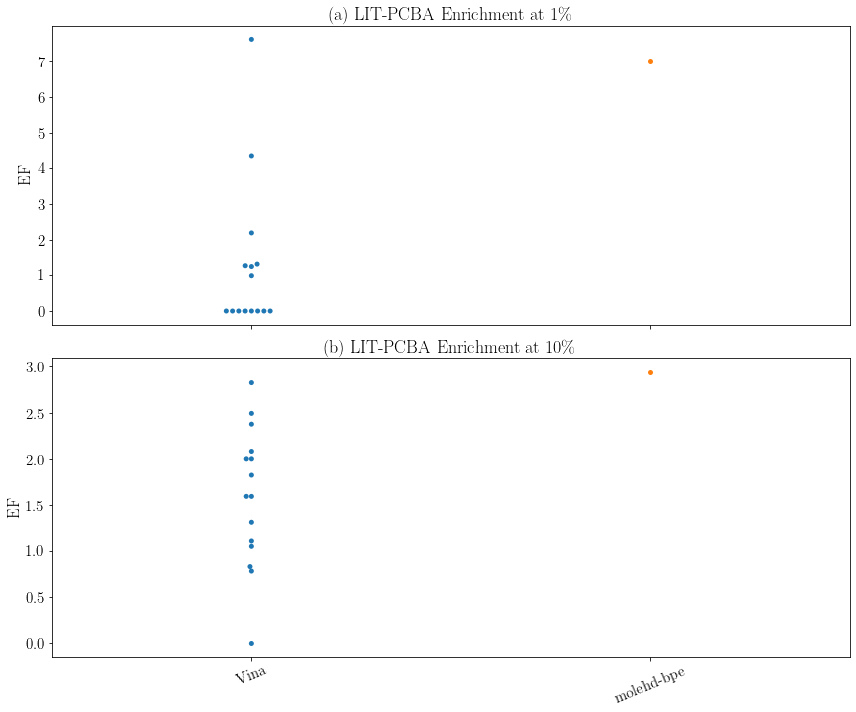

In [22]:
make_box_plot(enrich_1_df=grp_df[grp_df["p"] == .01], 
          enrich_10_df=grp_df[grp_df["p"] == .1])

- should add the average EF (median?) to the labels on the horizontal axis

In [18]:
def make_swarm_plot(enrich_1_df, enrich_10_df):

    enrich_f, enrich_ax = plt.subplots(2,1, figsize=(12,10), sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]
    
    sns.swarmplot(data=enrich_1_df, x="model", y="enrich", ax=enrich_1_ax, palette=color_dict)
    enrich_1_ax.set_title("(a) LIT-PCBA Enrichment at 1\%", fontdict={"fontsize": 18})
    enrich_1_ax.set_xlabel("")
    enrich_1_ax.set_ylabel("")
    enrich_1_ax.tick_params(axis="x", labelrotation=22.5)

    enrich_1_ax.set_ylabel("EF")

    plt.tight_layout()

    
    sns.swarmplot(data=enrich_10_df, x="model", y="enrich", ax=enrich_10_ax, palette=color_dict)
    enrich_10_ax.set_title("(b) LIT-PCBA Enrichment at 10\%", fontdict={"fontsize": 18})
    enrich_10_ax.set_xlabel("")
    enrich_10_ax.set_ylabel("")
    enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
    labels = [item.get_text() for item in enrich_10_ax.get_xticklabels()]
    labels = [model_name_dict[x.get_text()] for x in enrich_10_ax.get_xticklabels()]
#     labels[-1] = combo_model_name
    enrich_10_ax.set_xticklabels(labels)
    enrich_ax[0].set_ylabel("EF")
    enrich_ax[1].set_ylabel("EF")

    plt.tight_layout()
    # enrich_10_f.savefig("enrich_10.png", dpi=600, bbox_inches="tight")
    # enrich_10_f
    
    enrich_f.savefig("lit-pcba-enrich-swarm.png", dpi=600, bbox_inches="tight")

#     return enrich_f

NameError: name 'color_dict' is not defined

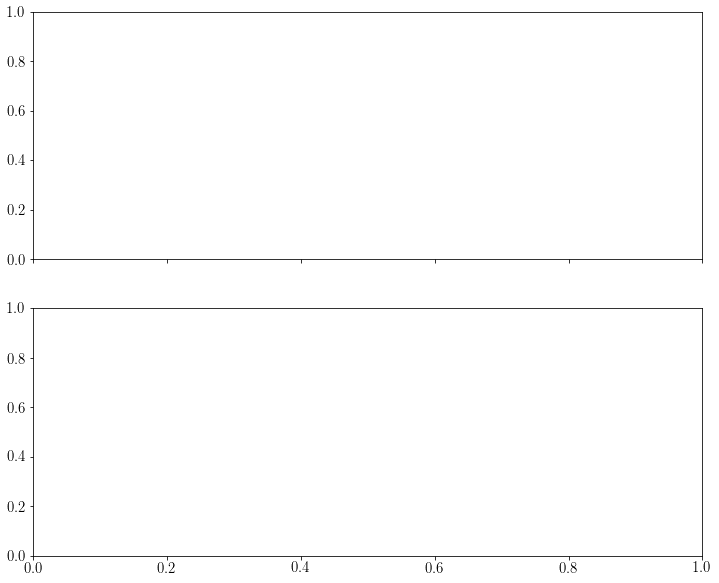

In [19]:
make_swarm_plot(enrich_1_df=grp_df[grp_df["p"] == .01], 
          enrich_10_df=grp_df[grp_df["p"] == .1])

In [ ]:
grp_df

In [ ]:
from pandas.plotting import parallel_coordinates

def make_pc_plot(df):

#     f, ax = plt.subplots(1,1, figsize=(12,10), sharex=True, sharey=False)

    df_list = list(df.groupby(["model"]))
    print(df_list)
#     pc_df = pd.concat([group_df for group_name, group_df in df.groupby('model')], axis=1)

    

#     ax = ax.flatten()
#     enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]
    
#     sns.swarmplot(data=model_1_df, x="model", y="enrich", ax=ax, palette=color_dict)
#     enrich_1_ax.set_title("(a) LIT-PCBA Enrichment at 1\%", fontdict={"fontsize": 18})
#     enrich_1_ax.set_xlabel("")
#     enrich_1_ax.set_ylabel("")
#     enrich_1_ax.tick_params(axis="x", labelrotation=22.5)

#     enrich_1_ax.set_ylabel("EF")

#     plt.tight_layout()

    
#     sns.swarmplot(data=enrich_10_df, x="model", y="enrich", ax=enrich_10_ax, palette=color_dict)
#     enrich_10_ax.set_title("(b) LIT-PCBA Enrichment at 10\%", fontdict={"fontsize": 18})
#     enrich_10_ax.set_xlabel("")
#     enrich_10_ax.set_ylabel("")
#     enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
#     labels = [item.get_text() for item in enrich_10_ax.get_xticklabels()]
#     labels = [model_name_dict[x.get_text()] for x in enrich_10_ax.get_xticklabels()]
#     labels[-1] = combo_model_name
#     enrich_10_ax.set_xticklabels(labels)
#     enrich_ax[0].set_ylabel("EF")
#     enrich_ax[1].set_ylabel("EF")

#     plt.tight_layout()
    # enrich_10_f.savefig("enrich_10.png", dpi=600, bbox_inches="tight")
    # enrich_10_f
    
#     enrich_f.savefig("lit-pcba-enrich-swarm.png", dpi=600, bbox_inches="tight")

#     return enrich_f
make_pc_plot(grp_df[grp_df["model"].apply(lambda x: x in  ["HDC-RF", "rf", "ecfp"])])

# Speedup

In [ ]:
def aggregate_time_results(dataset, range_limit=10):
    

    model_time_dict = {"model": [], "target": [], "seed": [],"train_time": [], "test_time": [], "train_size": [], "test_size": []}
    
    
    tokenizer="atomwise"
    ngram_order=0
    for model, color in tqdm(color_dict.items(), total=len(color_dict), position=0):
                        
        metric_list = []
        test_time_list = []
        train_size_list = []
        test_size_list = []
        target_size_list = []
        eta_list = []

        
        if model not in ["HDC-MLP", "HDC-RF"]:
            data_path_list = list(data_p.glob(f"{dataset.replace('-','_')}*.{model}*pkl"))

        elif model in ["HDC-MLP", "HDC-RF"]:
            data_path_list = list(data_p.glob(f"{dataset.replace('-','_')}*.ecfp*pkl"))
    
        for path in tqdm(data_path_list, total=len(data_path_list), position=1):

            
            with open(path, "rb") as handle:
                model_data_dict = pickle.load(handle)

            
            target = path.name.split(".")[1]
            
            tqdm.write(f"{target}, {path}, {model}")

            hd_cache_dir = f"/p/lustre2/jones289/hd_cache/125/ecfp/{dataset}/random"

            for seed in range(range_limit):
                    
                model_time_dict["model"].append(model)
                model_time_dict["target"].append(target)
                model_time_dict["seed"].append(seed)
                model_time_dict["train_time"].append(model_data_dict[seed]["train_time"])
                model_time_dict["test_time"].append(model_data_dict[seed]["test_time"])
                model_time_dict["train_size"].append(model_data_dict[seed]["train_size"])
                model_time_dict["test_size"].append(model_data_dict[seed]["test_size"])

                



    return model_time_dict
        


In [ ]:
time_dict = aggregate_time_results(dataset="lit-pcba", range_limit=10)
time_df = pd.DataFrame(time_dict)

In [ ]:
time_df["test_latency"] = time_df.apply(lambda x: x["test_time"]/x["test_size"], axis=1)

## averaging over seeds

In [ ]:
time_df.groupby(["model", "target"])["test_latency"].mean().reset_index()

## averaging over both seeds and target dimensions

In [ ]:
time_df.groupby(["model", "target"])["test_latency"].mean().reset_index().groupby("model")["test_latency"].median().reset_index()

In [ ]:
sns.boxplot(x="model", y="test_latency", data=time_df.groupby(["model", "target"])["test_latency"].mean().reset_index())